In [32]:
import pickle
import networkx as nx
import numpy as np
import polars as pl
from nx_landmarks import landmarks, selection_strategies
from tqdm import tqdm

In [33]:
G = nx.read_adjlist('Data/com-dblp_ungraph.csv')
G = nx.convert_node_labels_to_integers(G)

In [34]:
precomputed = {
    'rand':selection_strategies.random_ranking(G),
    'deg':selection_strategies.degree_ranking(G),
    'close':selection_strategies.closeness_ranking(G, k = 500),
    'between':selection_strategies.betweenness_ranking(G, k = 500),
}

In [35]:
landmarks_arr = [
    landmarks(G,10,['rand'],1, precomputed=precomputed),
    landmarks(G,10, [('deg',(1/3)), ('close',(1/3)), ('between',(1/3))],1, precomputed=precomputed),
    landmarks(G,10, [('close',(1/2)), ('between',(1/2))],1, precomputed=precomputed),
    landmarks(G,10,['deg'],1, precomputed=precomputed),
    landmarks(G,10,['close'],1, precomputed=precomputed),
    landmarks(G,10,['between'],1, precomputed=precomputed)
]
print('Done...')
for D in landmarks_arr:
    D.get_landmarks()


Done...


In [36]:
def sample_random_pairs(G,n = 1):
    choice = np.random.choice(G.nodes(),2*n,replace = False)
    pairs =[]
    for i in range(n):
        idx = 2*i
        pairs.append(((choice[idx]),choice[idx+1]))
    return pairs

def average_error(D,pairs,true = None):
    if true == None:
        true = [nx.shortest_path_length(G, source=s,target=t) for s,t in pairs]
    estimations = []
    for pair in pairs:
        estimations.append(D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    errors = [(e-t)/t for e,t in zip(estimations,true)]
    return sum(errors)/len(errors)

def average_LU_ratio(D,pairs):
    ratio = []
    for pair in pairs:
        ratio.append(D.shortest_path_estimation_lower_bound(pair[0],pair[1])/D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    return np.average(np.array(ratio))

In [37]:
def experiment_setup(G,landmarks:list)->list:
    
    results_rel_error = [[] for D in landmarks]
    results_lu_ratio = [[] for D in landmarks]
    
    for n_landm in tqdm(range(50,500,10)):
        for idx,D in enumerate(landmarks):
            result_err = []
            result_lu = []
            for i in range(10):
                result_err.append((average_error(D,sample_random_pairs(G,2000))))
                result_lu.append((average_LU_ratio(D,sample_random_pairs(G,2000))))
            results_rel_error[idx].append((np.average(np.array(result_err)),len(D.landmarks)))
            results_lu_ratio[idx].append((np.average(np.array(result_lu)),len(D.landmarks)))
            D.add_landmarks(10)
    return results_rel_error,results_lu_ratio

In [38]:
results_rel_error,results_lu_ratio = experiment_setup(G,landmarks_arr)

100%|██████████| 45/45 [37:52<00:00, 50.50s/it]


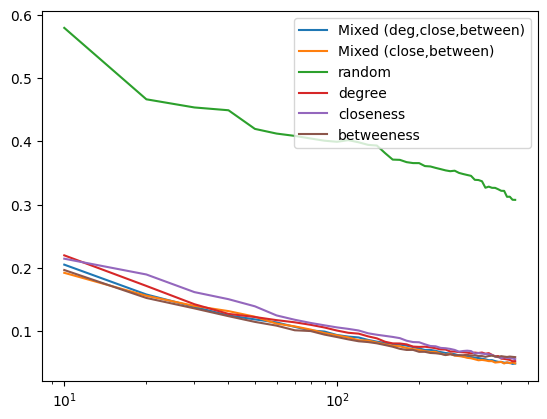

In [39]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
x = [a[1] for a in results_rel_error[1]]
y = [a[0] for a in results_rel_error[1]]
ax.plot(x,y, label = 'Mixed (deg,close,between)')
x = [a[1] for a in results_rel_error[2]]
y = [a[0] for a in results_rel_error[2]]
ax.plot(x,y, label = 'Mixed (close,between)')
x = [a[1] for a in results_rel_error[0]]
y = [a[0] for a in results_rel_error[0]]
ax.plot(x,y, label = 'random')
x = [a[1] for a in results_rel_error[3]]
y = [a[0] for a in results_rel_error[3]]
ax.plot(x,y, label = 'degree')
x = [a[1] for a in results_rel_error[4]]
y = [a[0] for a in results_rel_error[4]]
ax.plot(x,y, label = 'closeness')
x = [a[1] for a in results_rel_error[5]]
y = [a[0] for a in results_rel_error[5]]
ax.plot(x,y, label = 'betweeness')

ax.set_xscale('log')
ax.legend(loc = 'upper right')
plt.show()

In [40]:
for i in results_rel_error:
    print(i)

[(np.float64(0.5793207634032633), 10), (np.float64(0.4663785662948163), 20), (np.float64(0.45348497002997), 30), (np.float64(0.44905317474192474), 40), (np.float64(0.41958426282051275), 50), (np.float64(0.4122135206460206), 60), (np.float64(0.4084977634865135), 70), (np.float64(0.4044081505014593), 80), (np.float64(0.4009067292429792), 90), (np.float64(0.3992022714785215), 100), (np.float64(0.40180775890775894), 110), (np.float64(0.39839117077367076), 120), (np.float64(0.3943304313741814), 130), (np.float64(0.39328757228882233), 140), (np.float64(0.38135136988011986), 150), (np.float64(0.3710447287434787), 160), (np.float64(0.37062061272061275), 170), (np.float64(0.3669973715867466), 180), (np.float64(0.3655245594683095), 190), (np.float64(0.36547244925825806), 200), (np.float64(0.3607945482295482), 210), (np.float64(0.36018566267066265), 220), (np.float64(0.35790880378608325), 230), (np.float64(0.3559526239038739), 240), (np.float64(0.35398911387223886), 250), (np.float64(0.3526910722

In [41]:
average_error(landmarks_arr[1], sample_random_pairs(G,2000))

0.04815680014430014